In [3]:
!pip install segmentation_models_pytorch
import os
import numpy as np
from PIL import Image, ImageFilter, ImageDraw
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import albumentations as A  
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import torchvision.transforms.functional as TF
import segmentation_models_pytorch as smp
from IPython.display import clear_output
import cv2

clear_output() 

In [4]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

LEARNING_RATE = 3e-4
BATCH_SIZE    = 32 # 64
NUM_EPOCHS    = 10
IMAGE_HEIGHT  = 256  
IMAGE_WIDTH   = 256 #192  

MODEL_PATH = '/kaggle/working/model_jew_v15.04.2023.md'
INPUT_TRANSPARENT_DIR = '/kaggle/input/jewellery/raw_data_all/raw_data_all'
IMAGE_DIR = '/kaggle/working/images/'
MASK_DIR = '/kaggle/working/masks/'
INPUT_MANUAL_IMAGES_DIR = '/kaggle/input/jewellery/images_manual/images_manual/images'
INPUT_MANUAL_MASKS_DIR = '/kaggle/input/jewellery/images_manual/images_manual/masks'

REAL_PATH = '/kaggle/input/house-rooms-streets-image-dataset/kaggle_room_street_data/house_data'
HANDS_PATH = '/kaggle/input/hands-and-palm-images-dataset/Hands/Hands'
ROCK_PAPER_SCISSORS_PATH = '/kaggle/input/rock-paper-scissors-dataset/train'

cuda


In [6]:
def create_dir(newpath):
    if not os.path.exists(newpath):
        os.makedirs(newpath)
        
create_dir(IMAGE_DIR)
create_dir(MASK_DIR)

## Случайное изображение из датасета объектов

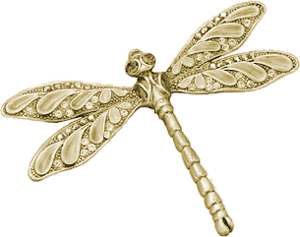

In [7]:
image_path = '/kaggle/input/jewellery/raw_data_all/raw_data_all/' + random.choice(os.listdir('/kaggle/input/jewellery/raw_data_all/raw_data_all'))
image = Image.open(image_path)#.convert('RGBA')#.getdata()
image

In [8]:
def generate_background(w : int, h : int, lighten_range = [0.05, 0.95], amount = 1):
    '''
    Создает размытый фон, поверх которого можно накладывать изображение
    :param h: высота фона
    :param w: ширина фона
    :param lighten_range: задает тон
    :param amount: задает зернистость    
    :return: изображение типа Image формата RGBA    
    '''
    white_list = np.zeros((h,w,3))
    max_col = 255

    amount = 1
    # add salt
    nb_salt = np.ceil(amount * white_list.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(nb_salt)) for i in white_list.shape]
    white_list[coords] = 0

    # add pepper
    nb_pepper = np.ceil(amount* white_list.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(nb_pepper)) for i in white_list.shape]
    white_list[coords] = 1

    lighten = np.array([random.uniform(*lighten_range) for i in range(3)]) 

    white_list = 1-(1-white_list)*lighten

    white_list = Image.fromarray((white_list * max_col).astype(np.uint8))
    white_list = white_list.filter(ImageFilter.GaussianBlur(5))    

    
    draw = ImageDraw.Draw(white_list)
    
    if random.random() > 0.25:
        for i in range( random.randint(1,6)):
            x1, x2 = random.randint(0, w), random.randint(0, w),
            y1, y2 = random.randint(0, w), random.randint(0, w),
            x1, x2 = min(x1, x2), max(x1, x2),
            y1, y2 = min(y1, y2), max(y1, y2),
            color1 = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            color2 = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

            draw.rectangle((x1, y1, x2, y2), fill=color1, outline=color2)
        
    if random.random() > 0.75:
        for i in range( random.randint(1,6)):
            x1, x2 = random.randint(0, w), random.randint(0, w),
            y1, y2 = random.randint(0, w), random.randint(0, w),
            color1 = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            width1 = random.randint(0, 20)
            draw.line((x1, y1, x2, y2), fill=color1, width=width1)               
        
    if random.random() > 0.75:
        for i in range( random.randint(1,6)):
            x1, x2 = random.randint(0, w), random.randint(0, w),
            y1, y2 = random.randint(0, w), random.randint(0, w),
            x1, x2 = min(x1, x2), max(x1, x2),
            y1, y2 = min(y1, y2), max(y1, y2),
            color1 = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            color2 = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            draw.ellipse((x1, y1, x2, y2), fill=color1, outline=color2)       
        
    white_list = white_list.filter(ImageFilter.GaussianBlur(1))    

    
    return white_list

## Пример генерации фона

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


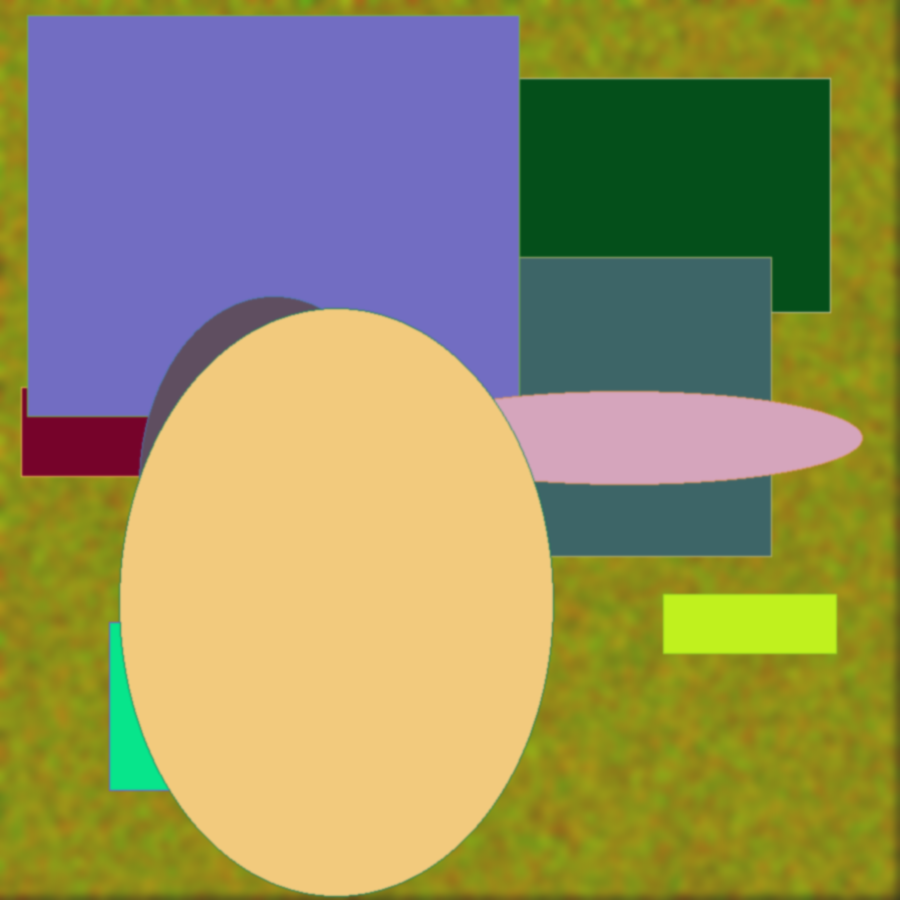

In [150]:
background = generate_background(*image.size)
background

In [151]:
def get_real_background():
    '''
    Создает фон, из датасетов реальных картинок, среди которых могут быть
    - комнаты с интерьером
    - руки
    :return: изображение типа Image формата RGB размером (IMAGE_WIDTH, IMAGE_HEIGHT)   
    '''
    
    if random.random() > 0.5:
        path = REAL_PATH
    else:
        path = os.path.join(ROCK_PAPER_SCISSORS_PATH, random.choice(['paper', 'rock', 'scissors']) )
        
                
    real_images_list = os.listdir(path)    
    image_name = random.choice(real_images_list)   
    img_path = os.path.join(path, image_name)            
    image = Image.open(img_path)
            
    image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))      
    return image  

In [152]:
def add_background(image):
    '''
    Накладывает изобрежание image на случайный фон, который может быть или сгенерированным, или реальным.
    :param image: изображение типа PIL Image   
    :return: изображение типа Image формата RGB размером (IMAGE_WIDTH, IMAGE_HEIGHT)
    '''    
    image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))          
    
    h = image.size[0]
    w = image.size[1]
    
    if random.random() > 0.66:
        output = generate_background(h,w)
    else:
        output = get_real_background()
        
    output.paste(image, (0,0), image)
    output = output.convert('RGB')
    return output

## Пример маски для сегментации

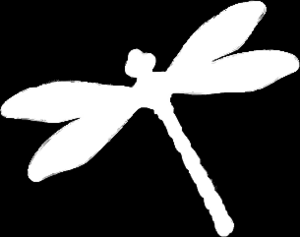

In [12]:
mask = image.getchannel(3)
mask

## Пример объета, наложенного на фон

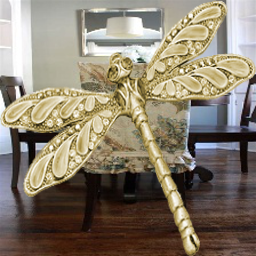

In [13]:
output = add_background(image)
output

In [14]:
def add_dataset_from_images_transparency(folder_from:str, folder_images_to:str, folder_masks_to, n=1):
    '''
    Генерирует изображения, беря картинки из folder_from и помещает folder_images_to. Повторяет n раз.    
    :param folder_from: 
    :param folder_images_to: 
    :param n: задает тон
    :return: None
    '''    
    list_dir = os.listdir(folder_images_to)
    if len(list_dir) == 0:
        i = 0
    else:
        i = max([int(name.split('.')[0]) for name in list_dir])       
    
    counter = 0
    len_list_to = len(os.listdir(folder_from))
    for image_name in os.listdir(folder_from):

        
        for _ in range(n):
            i += 1
            counter += 1            
            
            img_path = os.path.join(folder_from, image_name)            
            image = Image.open(img_path)
            
            image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
            
            mask = image.getchannel(3)
            im = add_background(image)
   
            img_path = os.path.join(folder_images_to, f'{i}.png')        
            im.resize((IMAGE_WIDTH, IMAGE_HEIGHT)).save(img_path)

            img_path = os.path.join(folder_masks_to, f'{i}.png')       
            mask.resize((IMAGE_WIDTH, IMAGE_HEIGHT)).save(img_path)  
            
            clear_output(wait=True)
            r = counter / len_list_to / n
            print(f'created {100*r:.2f}% images')
     
    clear_output(wait=True)    
    print(f'created {counter} images')

In [ ]:
add_dataset_from_images_transparency(INPUT_TRANSPARENT_DIR, IMAGE_DIR, MASK_DIR, n=10)

created 63.88% images


In [39]:
# проверка количества сгенерированных изображений
names = os.listdir(IMAGE_DIR)
len(names)

13510

In [40]:
def add_dataset_from_images_manual(folder_from_images:str, folder_from_masks:str, folder_images_to:str, folder_masks_to:str):
    '''
    Импортирует изображения после ручной разметки, беря картинки из folder_from и folder_from_masks и помещает в folder_images_to и folder_masks_to.    
    :param folder_from_images: 
    :param folder_from_masks:     
    :param folder_images_to: 
    :param folder_masks_to: 
    :return: None
    '''        
    names = os.listdir(folder_from_images)
    short_names = [name.split('.')[0] for name in names]
    
    list_dir = os.listdir(folder_images_to)
    if len(list_dir) == 0:
        i = 0
    else:
        i = max([int(name.split('.')[0]) for name in list_dir])        
       
    counter = 0 
    for name in short_names:
        img_path = os.path.join(folder_from_masks, f'{name}.png')       
        mask = Image.open(img_path)  
        mask = mask.convert('RGB')
        find_mask = (np.array(mask.getchannel(0)) != 252)    
        find_mask_mean = find_mask.mean()
        if find_mask_mean > 0.5 or find_mask_mean < 0.01:
            continue

        i += 1
        counter += 1
        mask = Image.fromarray(find_mask)
        img_path = os.path.join(folder_masks_to, f'{i}.png')       
        mask.resize((IMAGE_WIDTH, IMAGE_HEIGHT)).save(img_path)  

        img_path = os.path.join(folder_from_images, f'{name}.jpg')       
        image = Image.open(img_path)
#         image = convertImageFormat(image, 'PNG')
        img_path = os.path.join(folder_images_to, f'{i}.jpg')           
        image.resize((IMAGE_WIDTH, IMAGE_HEIGHT)).save(img_path)
        
    print(f'created {counter} images')        

In [41]:
# add_dataset_from_images_manual(INPUT_MANUAL_IMAGES_DIR, INPUT_MANUAL_MASKS_DIR, IMAGE_DIR, MASK_DIR)

In [42]:
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        ToTensorV2(),
    ],
)

val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        ToTensorV2(),
    ],
)


def my_segmentation_transforms(image0, segmentation0):    
    image = TF.to_tensor(image0)
    segmentation = TF.to_tensor(segmentation0)
    
    if random.random() > 0.5:
        angle = random.choice([-90,90,180])        
        image = TF.rotate(image, angle)
        segmentation = TF.rotate(segmentation, angle)        
        
    if random.random() > 0.7:        
        image = TF.hflip(image)
        segmentation = TF.hflip(segmentation)
             
    if random.random() > 0.7:        
        image = TF.adjust_hue(image, 0.2-0.4*(random.random())   )
             
    if random.random() > 0.7:        
        image = TF.adjust_contrast(image, 0.8+0.4*(random.random())  )
        
    image = TF.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])
    segmentation = TF.resize(segmentation, [IMAGE_HEIGHT, IMAGE_WIDTH])                      
    return image, segmentation

In [43]:
def get_random_image_and_mask():
    image_path = '/kaggle/input/jewellery/raw_data_all/raw_data_all/' + random.choice(os.listdir('/kaggle/input/jewellery/raw_data_all/raw_data_all'))
    image = Image.open(image_path)
    image
    mask = image.getchannel(3)
    im = add_background(image)
    return image, im, mask

def test_segmentation_transforms():
    image, img, mask = get_random_image_and_mask()
    img, mask = my_segmentation_transforms(img, mask)    
    
    plt.figure( figsize=(15, 5))    
    plt.subplot(131)       
    plt.imshow(image)     
    plt.subplot(132)    
    plt.imshow(img.permute(1, 2, 0)) 
    plt.subplot(133)    
    plt.imshow(mask.numpy()[0], cmap='gray')    

## Проверка работы аугментации

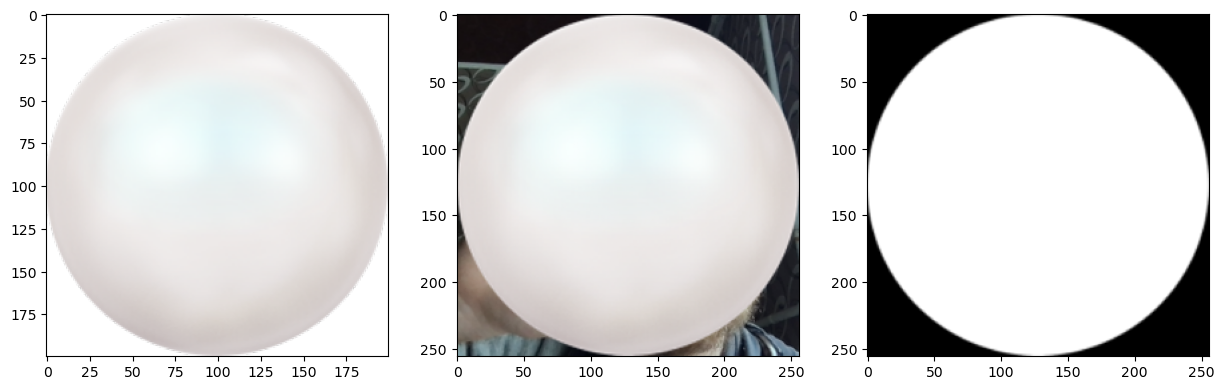

In [46]:
test_segmentation_transforms()

In [154]:
# Проверяем количество изображений и масок
print('Количество изображений')
print(len(os.listdir(IMAGE_DIR)))
print('Количество масок')
print(len(os.listdir(MASK_DIR)))

Количество изображений
13510
Количество масок
13510


In [48]:
class SegmentationDataset(Dataset):
    def __init__(self, dir_images, dir_masks, is_train='train', transform=None, my_segmentation_transforms = None):
        self.dir_images  = dir_images
        self.dir_masks  = dir_masks     
        
        self.transform  = transform
        self.is_train = is_train
        self.my_segmentation_transforms = my_segmentation_transforms
        
        if is_train == 'train':
            x = round(len(os.listdir(dir_images)) * 0.8)
            self.images = os.listdir(dir_images)[:x]
#             self.masks = os.listdir(dir_masks)[:x]           
            
        elif is_train == 'test':
            x = round(len(os.listdir(dir_images)) * 0.8)
            self.images = os.listdir(dir_images)[x:]
                     
        else: # for validation on aaa dataset
            self.images = os.listdir(dir_images)            
            

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path_image = os.path.join(self.dir_images, self.images[index])   
        image = Image.open(img_path_image)
        
        if self.is_train in ['train', 'test']:
            img_path_mask = os.path.join(self.dir_masks, self.images[index])               
            img_path_mask = img_path_mask.split('.')[0]+'.png'            
            mask = Image.open(img_path_mask)
        
        if self.is_train == 'train':
            image = np.array(image, dtype=np.float32) / 255      
            mask = np.array(mask, dtype=np.float32) / 255                         
            img, mask = self.my_segmentation_transforms(image, mask)
            return img, mask              
        elif self.is_train == 'test':
            image = np.array(image, dtype=np.float32) / 255      
            mask = np.array(mask, dtype=np.float32) / 255                         
            img, mask = self.my_segmentation_transforms(image, mask)
            return img, mask          
        else: # for validation on aaa dataset
            image = np.array(image, dtype=np.float32) / 255      
            augmentations = self.transform(image=image)                
            img = augmentations["image"]
            return img    

In [49]:
train_ds = SegmentationDataset(IMAGE_DIR, MASK_DIR, is_train='train', my_segmentation_transforms = my_segmentation_transforms)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

val_ds = SegmentationDataset(IMAGE_DIR, MASK_DIR, is_train='test', my_segmentation_transforms = my_segmentation_transforms)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True)

## Проверка работы DataLoader

In [50]:
inputs, masks = next(iter(train_loader))

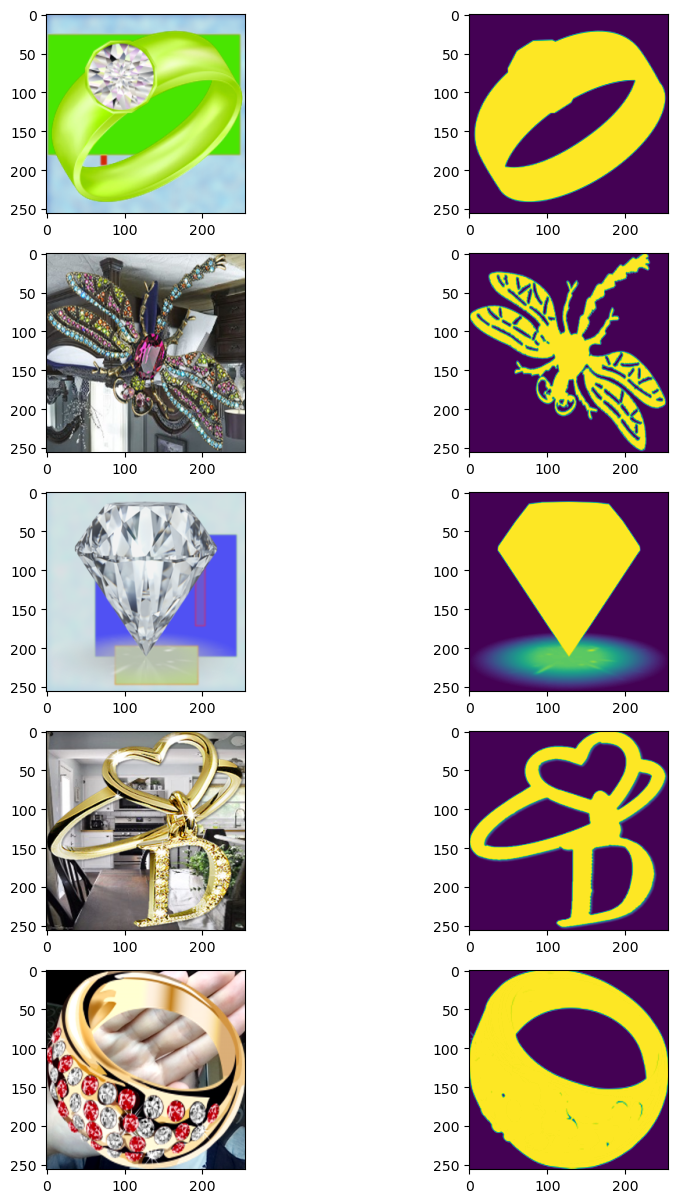

In [53]:
rows = 5
_, ax = plt.subplots(rows, 2, figsize=(10,15))
for k in range(rows):
    ax[k][0].imshow(inputs[k].permute(1,2,0))    
    ax[k][1].imshow(np.squeeze(masks[k].numpy(), axis=0))    

## Обучение модели

In [54]:
def check_accuracy(loader, model, device="cuda"):
    '''
    Функция выводит на экран метрики Accuracy и Dice score
    '''
    num_correct = 0
    num_pixels  = 0
    dice_score  = 0
    model.eval()

    with torch.no_grad():
        for img, mask in tqdm(loader):
            img   = img.to(device)            
            
#             mask  = mask.to(device).unsqueeze(1)
            mask  = mask.to(device)
            preds = torch.sigmoid(model(img))
            preds = (preds > 0.5).float()    
            
            num_correct += (preds == mask).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * mask).sum()) / (
                (preds + mask).sum() + 1e-7
            )

    print(
        f"Got {num_correct}/{num_pixels} with pixel accuracy {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)*100:.2f}")
    model.train()

In [55]:
# modelX = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, num_classes=10)

# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# modelX = FastRCNNPredictor(in_channels=3, num_classes=2)

# def create_model(num_classes, pretrained=False):
#     model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained)
#     in_features = model.roi_heads.box_predictor.cls_score.in_features
#     model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
#     return model

# model = create_model(num_classes=1, pretrained=True)

model = smp.Unet(encoder_name='efficientnet-b3', in_channels=3, classes=1, activation=None)
model= nn.DataParallel(model)
model = model.to(DEVICE)

In [56]:
loss_fn   = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [63]:
def train_fn(loader, model, optimizer, loss_fn):
    loop = tqdm(loader)

    for batch_idx, (image, mask) in enumerate(loop):
        image   = image.to(device=DEVICE)
        mask    = mask.float().to(device=DEVICE)

#         model.eval()
        predictions = model(image)
#         model.train()
           
        loss = loss_fn(predictions, mask)
        model.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())

In [66]:
def remove_background_tensor(image, mask): # Tensor to RGBA format
    '''
    Убирает с изображение image фон по маске mask.
    :param image: 
    :param mask:   
    :return: Изображение формата PIL Image режима RGBA
    '''       
    x = image.permute(1,2,0).numpy()  
    m = mask.permute(1,2,0).numpy() 
    
    im_rgba = np.concatenate((x,m), axis=2) 
    im_rgba = (im_rgba*255).astype(np.uint8)
    im_rgba = Image.fromarray(im_rgba)  

    return im_rgba    

In [68]:
for epoch in range(NUM_EPOCHS):

    print('########################## epoch: '+str(epoch))
    train_fn(train_loader, model, optimizer, loss_fn)
    
    # check accuracy
    check_accuracy(val_loader, model, device=DEVICE)
    
    torch.save(model.state_dict(), MODEL_PATH)

########################## epoch: 0


100%|██████████| 85/85 [00:35<00:00,  2.36it/s]


Got 158108156/177078272 with pixel accuracy 89.29
Dice score: 94.74
########################## epoch: 1


100%|██████████| 85/85 [00:35<00:00,  2.43it/s]


Got 158618254/177078272 with pixel accuracy 89.58
Dice score: 95.40
########################## epoch: 2


100%|██████████| 85/85 [00:34<00:00,  2.44it/s]


Got 158878006/177078272 with pixel accuracy 89.72
Dice score: 95.82
########################## epoch: 3


100%|██████████| 85/85 [00:35<00:00,  2.42it/s]


Got 159014680/177078272 with pixel accuracy 89.80
Dice score: 96.01
########################## epoch: 4


100%|██████████| 85/85 [00:36<00:00,  2.36it/s]


Got 159021216/177078272 with pixel accuracy 89.80
Dice score: 96.08
########################## epoch: 5


100%|██████████| 85/85 [00:35<00:00,  2.40it/s]


Got 159043137/177078272 with pixel accuracy 89.82
Dice score: 96.11
########################## epoch: 6


100%|██████████| 85/85 [00:34<00:00,  2.47it/s]


Got 159171301/177078272 with pixel accuracy 89.89
Dice score: 96.24
########################## epoch: 7


100%|██████████| 85/85 [00:34<00:00,  2.49it/s]


Got 159161776/177078272 with pixel accuracy 89.88
Dice score: 96.28
########################## epoch: 8


100%|██████████| 85/85 [00:34<00:00,  2.49it/s]


Got 159220116/177078272 with pixel accuracy 89.92
Dice score: 96.39
########################## epoch: 9


100%|██████████| 85/85 [00:34<00:00,  2.48it/s]

Got 159322462/177078272 with pixel accuracy 89.97
Dice score: 96.52


In [70]:
# if torch.cuda.is_available():
#     model.load_state_dict(torch.load('/kaggle/input/jewellery/models/model_jew_v13.04.2023.md'))
# else:    
#     model.load_state_dict(torch.load('/kaggle/input/jewellery/models/model_jew_v13.04.2023.md', map_location=torch.device('cpu')))

model.eval()
print()

## Проверяем работу модели на сгенерированных изображениях

In [71]:
inputs, masks = next(iter(val_loader))
output        = ((torch.sigmoid(model(inputs.to(DEVICE)))) >0.5).float()

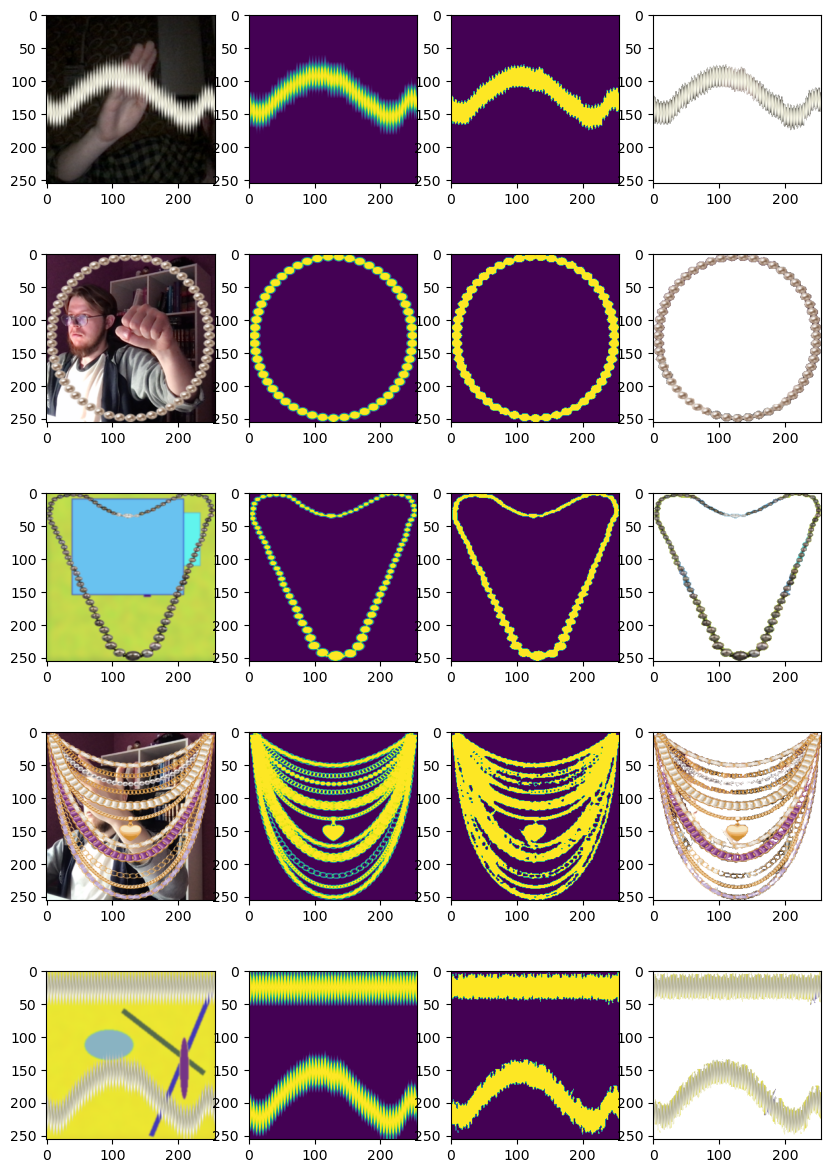

In [72]:
rows = 5
_, ax = plt.subplots(rows,4, figsize=(10,15))
for k in range(rows):
    ax[k][0].imshow(inputs[k].permute(1,2,0))
    ax[k][1].imshow(np.squeeze(masks[k]))
    
    if torch.cuda.is_available():
        out = output[k].cpu()
    else:
        out = output[k]
    
    ax[k][2].imshow(out.permute(1,2,0))

    q = remove_background_tensor(inputs[k], out)
    qq = np.array(q, dtype=np.float32)/ 255  
    ax[k][3].imshow(qq)    

## Проверяем работу модели на изображениях Авито

In [73]:
aaa_ds = SegmentationDataset('/kaggle/input/jewellery/aaa-jewellery-images/aaa-jewellery-images/', _, is_train='control', transform=val_transform)
aaa_loader = DataLoader(aaa_ds, batch_size=BATCH_SIZE, shuffle=True)

In [74]:
aaa_inputs = next(iter(aaa_loader))

In [75]:
aaa_raw_output = torch.sigmoid(model(aaa_inputs.to(DEVICE)))

In [76]:
aaa_output = (aaa_raw_output>0.5).float()

In [201]:
def assurance(t) -> float:
    '''
    Выводит уверенность модели от 0 до 1 - на сколько близки все значения к 0 или 1
    :param t: Tensor
    :return: float
    '''  
    result = 2 * (0.5 - (0.5 - (t - 0.5).abs()).mean())
    result = float(result)
    return result

In [202]:
def assurance_in_mask(t) -> float:
    '''
    Выводит уверенность модели от 0 до 1 - по пикселям внутри маски - на сколько близки все значения к 1
    :param t: Tensor
    :return: float
    '''  
    r_mask = (t > 0.5).float().sum() / t.size()[1] / t.size()[2]

    ins = (t > 0.5).float() * t / r_mask
    ins = ins.mean()
    return float(ins)

In [205]:
def assurance_out_mask(t) -> float:
    '''
    Выводит уверенность модели от 0 до 1 - по пикселям вне маски (фон) - на сколько близки все значения к 0
    :param t: Tensor
    :return: float
    '''  
    r_mask = (t < 0.5).float().sum() / t.size()[1] / t.size()[2]
    outs = (t < 0.5).float() * (1-t) / r_mask
    outs = outs.mean()
    return float(outs)

In [206]:
assurance(aaa_raw_output[5])

0.9505228400230408

In [207]:
assurance_in_mask(aaa_raw_output[5])

0.9834738969802856

In [208]:
assurance_out_mask(aaa_raw_output[5])

0.9834738969802856

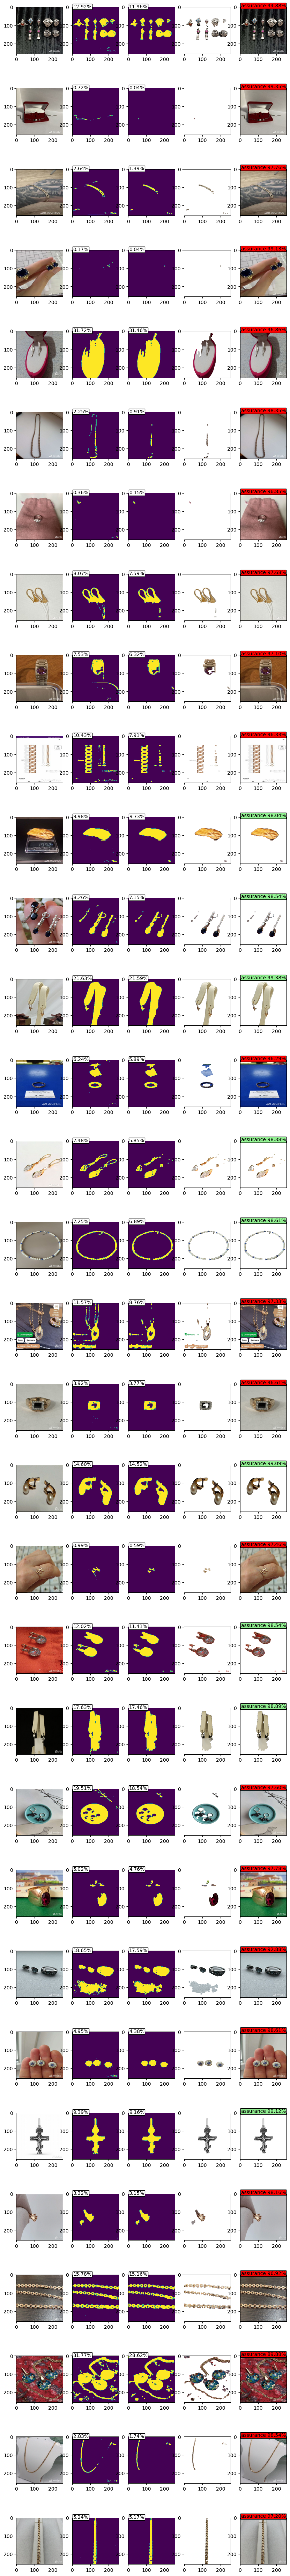

In [217]:
rows = 32

mean_values = [x.cpu().mean().tolist() for x in aaa_output]

_, ax = plt.subplots(rows, 5, figsize=(10,3 * rows))
for k in range(rows):
    
    # столбец 1 - анализируемое изображение
    ax[k][0].imshow(aaa_inputs[k].permute(1,2,0))
        
    # столбец 2 - маска, созданная моделью      
    if torch.cuda.is_available():
        out = aaa_output[k].cpu()
    else:
        out = aaa_output[k]
        
    ax[k][1].imshow(out.permute(1,2,0))
    ax[k][1].text(5, 5, f'{100*mean_values[k]:.2f}%', bbox={'facecolor': 'white', 'pad': 1})

    # столбец 3 - маска, с постобработкой 
    # убираем шумы и тонкие линии
    tensor_to_pil_image = torchvision.transforms.ToPILImage()
    pil_image = tensor_to_pil_image(out)
    pil_image = pil_image.filter(ImageFilter.MinFilter(5))
    out1 = pil_image.filter(ImageFilter.MaxFilter(5))    
    ax[k][2].imshow(out1)    
    pil_image_to_tensor = torchvision.transforms.ToTensor()
    out1 = pil_image_to_tensor(out1)
    m = out1.mean()
    ax[k][2].text(5, 5, f'{100*m:.2f}%', bbox={'facecolor': 'white', 'pad': 1})
        

    # столбец 4 - результат обработки фона        
        
    image_with_no_background = remove_background_tensor(aaa_inputs[k], out1)
    image_with_no_background = np.array(image_with_no_background, dtype=np.float32)/ 255  
    ax[k][3].imshow(image_with_no_background)   
    
    # столбец 5 - результат обработки фона вместе с решением выводить или нет

    a1 = assurance_in_mask(aaa_raw_output[k])
    a2 = assurance_out_mask(aaa_raw_output[k])  
    a = min(a1, a2)
    # если площадь маски очень большая или очень маленькая, то ничего не делаем
    if m > 0.5 or m < 0.05 or a < 0.98:
        out1 = torch.ones(out.shape)
        color = 'red'
    else: 
        color = 'lightgreen'
        
    image_with_no_background = remove_background_tensor(aaa_inputs[k], out1)
    image_with_no_background = np.array(image_with_no_background, dtype=np.float32)/ 255  
    ax[k][4].imshow(image_with_no_background)          
    ax[k][4].text(5, 0, f'assurance {100*a:.2f}%', bbox={'facecolor': color, 'pad': 1}) 